# Import libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from numba import jit, njit
from numba import cuda, void

# In-Class Problem: Ising Model

## Application of the Metropolis Method

The following code simulates the Ising model in 2D using the Metropolis algorithm. The main steps of Metropolis algorithm are:

1. Prepare an initial configuration of N spins
2. Flip the spin of a randomly chosen lattice site.
3. Calculate the change in energy dE.
4. If dE < 0, accept the move. Otherwise accept the move with probability $e^{-dE/T}$. This satisfies the detailed balance condition, ensuring a final equilibrium state.
5. Repeat 2-4.

In the code below, we have estimated and plotted energy, magnetization, specific heat and susceptibility of the system.

In [27]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------

def initialstate(N):   
    
    ''' Generate a random spin configuration for initial condition'''
    
    # Complete in-class
    #
    # generate the initial lattice of size NxN
    # with a random choice of +1 or -1 for each site
    #
    
    state = 2*np.random.randint(2, size=(N,N))-1
    state = state.astype('float32')
    
    # return the state
    return state

@cuda.jit
def mcmove(config, temp):
    
    '''Monte Carlo move using Metropolis algorithm '''
    i, j = cuda.grid(2)
    if i >= config.shape[0] or j >= config.shape[1]:
        return None
            
    #
    # get the configuration for a random site
    #
    a = np.random.randint(0, N)
    b = np.random.randint(0, N) 
    s =  config[a, b]
    
    #
    # calculate the change in energy, dE
    #
    # HINT: calculate the sum over all neighest neighbors using
    sum_nn = config[(a+1)%N,b] + config[a,(b+1)%N] + \
         config[(a-1)%N,b] + config[a,(b-1)%N]
    # where a & b are the index positions of random site
    # and %N allows for periodic boundary conditions
    new_spin = -config[a,b]
    dE = (config[a,b]-new_spin)*sum_nn #alt: 2*s*sum_nn
    
    #
    # if dE < 0, accept the spin flip
    # otherwise accept the move with probability exp^{-dE/T}
    #
    
    #min_value = np.min([1., np.exp(-dE/temp)])
    if dE < 0:
        s = new_spin
    elif np.random.rand() <  np.exp(-dE/temp): #min_value:
        s = new_spin
    #    
    # update the site
    #       
    config[a, b] = s
       
    # return the configuration
    return None


def configPlot(f, config, i, N, n_):

    ''' Plot the configuration once passed to it along with time etc '''

    X, Y = np.meshgrid(range(N), range(N))
    sp =  f.add_subplot(3, 3, n_ )  
    plt.setp(sp.get_yticklabels(), visible=False)
    plt.setp(sp.get_xticklabels(), visible=False)      
    plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu);
    plt.title('Time=%d'%i); plt.axis('tight')


In [28]:
# initialize the size of the lattice & temperature, number of time steps
N = 64; temp = 2; msrmnt = 1001

# make some initial move from the initial state
threadsperblock = (16, 16)
blockspergrid_x = np.ceil(N / threadsperblock[0]).astype('int')
blockspergrid_y = np.ceil(N / threadsperblock[1]).astype('int')
blockspergrid = (blocks_per_grid_x, blocks_per_grid_y)
config = initialstate(N)
mcmove[blockspergrid, threadsperblock](config, temp)

# create figure
f = plt.figure(figsize=(15, 15), dpi=80);    

# add the initial move to the plot
configPlot(f, config, 0, N, 1);

# loop over all steps
for i in range(msrmnt):
    
    # calculate the new configuration
    config = mcmove(config, temp)
    
    # plot at selected time steps
    if i == 1:       configPlot(f, config, i, N, 2);
    if i == 4:       configPlot(f, config, i, N, 3);
    if i == 32:      configPlot(f, config, i, N, 4);
    if i == 100:     configPlot(f, config, i, N, 5);
    if i == 1000:    configPlot(f, config, i, N, 6);
        
# note: this cell may take some time to finish executing

/home/jwise/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in method rand of numpy.random.mtrand.RandomState object at 0x7f52579c8940>) found for signature:
 
 >>> rand()
 
There are 2 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload in function 'rand': File: numba/cpython/randomimpl.py: Line 1882.
        With argument(s): '()':[0m
[1m       Rejected as the implementation raised a specific error:
         TypeError: Failed in cuda mode pipeline (step: fix up args)
       Signature mismatch: 0 argument types given, but function takes 1 arguments[0m
  raised from /home/jwise/.local/lib/python3.10/site-packages/numba/core/untyped_passes.py:125
[0m
[0m[1mDuring: resolving callee type: Function(<built-in method rand of numpy.random.mtrand.RandomState object at 0x7f52579c8940>)[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_611395/1040389475.py (55)
[0m
[1m
File "../../../../tmp/ipykernel_611395/1040389475.py", line 55:[0m
[1m<source missing, REPL/exec in use?>[0m


# Site Percolation: Example

Example for one probability:

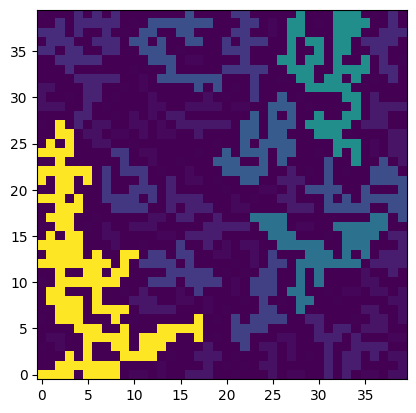

In [4]:
# define lattice size
L=40 
# define probability 
p=0.5 

# create random numbers
z=np.random.rand(L,L) 
# see if less than p
m=z<p 

# measure the clusters based on connectivity
lw,num=ndimage.label(m) 
# lw: matrix for each site in the original array tells what cluster it belongs to
# num: # of unique clusters

# color the clusters based on the size of the clusters 
area=ndimage.sum(m,lw,index=np.arange(num+1)) 
areaImg=area[lw]

plt.imshow(areaImg,origin='lower')

Vary the probability:

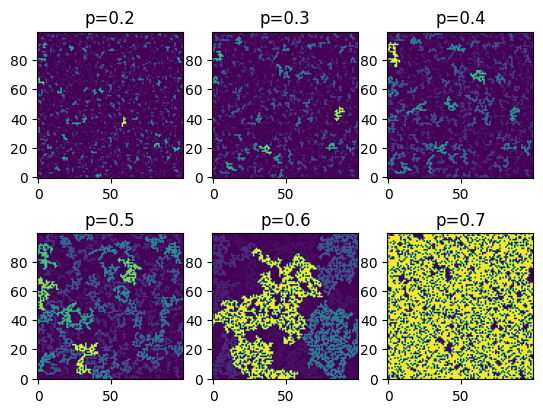

In [5]:
# define # of lattice sites
L=100 
# create random lattice of LxL
z=np.random.rand(L,L) 
# define percolation probabilites
pv=[0.2,0.3,0.4,0.5,0.6,0.7] 

# loop over all probabilities
for i in range(len(pv)): 
    
    # get site percolation for loop iteration
    # find where random matrix is less than threshold
    p=pv[i] 
    m=z<p 
    
    # measure the clusters based on connectivity
    lw,num=ndimage.label(m) 
    # lw: matrix for each site in the original array tells what cluster it belongs to
    # num: # of unique clusters
    
    # color the clusters based on the size of the clusters 
    area=ndimage.sum(m,lw,index=np.arange(num+1)) 
    areaImg=area[lw]
    
    # create plot
    plt.subplot(2,3,i+1) 
    plt.imshow(areaImg,origin='lower') 
    plt.title('p='+str(p)) 
    plt.axis()

Calculate the percolation probability, $\Pi(p,L)$:

Text(0, 0.5, '$\\Pi(p,L)$')

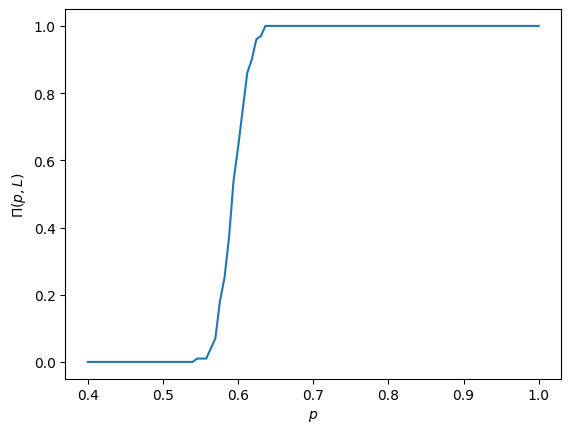

In [6]:
# generate sequence of 100 p_i
p=np.linspace(0.4,1.0,100)
# prepare arraies with same size of p
Ni= np.zeros(len(p)); P=np.zeros(len(p))

# define # of samples 
N=100
# define size of matrix
L=100 

# loop over all samples, for each sample generate new random matrix
for i in range(N): 
    z=np.random.rand(L,L) 
    for ip in range(len(p)): 
        m=z<p[ip] 
        lw,num=ndimage.label(m) 
        perc_x=np.intersect1d(lw[0,:],lw[-1,:]) 
        perc=perc_x[np.where(perc_x>0)] 
        if(len(perc)>0):
            Ni[ip]=Ni[ip]+1 
Pi=Ni/N 
plt.plot(p,Pi) 
plt.xlabel('$p$') 
plt.ylabel('$\Pi(p,L)$')